In [4]:
import pandas as pd
import numpy as np
from os.path import join as pjoin

import matplotlib.pyplot as plt
import matplotlib as mpl
from spks.event_aligned import population_peth
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', 100)

new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['font.size'] = 12

%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
animal = 'GRB006'  # example animal
session = '20240723_142451'  # example session

data_dir = '/Users/gabriel/data'
trial_ts = pd.read_pickle(pjoin(data_dir, animal, session, "pre_processed", "trial_ts.pkl"))
spike_times_per_unit = np.load(pjoin(data_dir, animal, session, "pre_processed", "spike_times_per_unit.npy"), allow_pickle=True)

In [ ]:
# Define variables
all_stims = np.hstack(np.array(trial_ts.stim_ts.dropna()))

post_seconds = 0.15
bin_size = 0.025  # 10ms bins
start_time = all_stims[0]
end_time = all_stims[-1] + post_seconds

# Create time bins
time_bins = np.arange(start_time, end_time + bin_size, bin_size)
combined_bins = np.union1d(time_bins, all_stims)
combined_bins.sort()
time_bins = combined_bins

# Bin spike times for each unit
n_units = len(spike_times_per_unit)
n_bins = len(time_bins) - 1
binned_spike_rate = np.zeros((len(time_bins) - 1, n_units))

# for unit_idx, spike_times in enumerate(spike_times_per_unit):
#     counts, _ = np.histogram(spike_times, bins=time_bins)
#     binned_spike_rate[:, unit_idx] = counts / bin_size

# Create stimulus indicator vectors
stim_indicator = np.zeros(len(time_bins) - 1)
stim_indices = np.searchsorted(time_bins[:-1], all_stims, side='right') - 1
stim_indicator[stim_indices] = 1

# Check that the alignment is correct
tolerance = 1e-6
retrieved_stim_times = time_bins[stim_indices]
time_differences = all_stims - retrieved_stim_times
alignment_check = np.all(np.abs(time_differences) < tolerance)
print(f"All stim_indices align with all_stims within tolerance: {alignment_check}")

if alignment_check:
    # Construct design matrix with time lags
    n_timepoints = np.round(0.15/bin_size).astype(int)  # Number of time lags
    design_matrix = np.zeros((n_bins, n_timepoints))

    for lag in range(n_timepoints):
        if lag == 0:
            design_matrix[:, lag] = stim_indicator
        else:
            design_matrix[lag:, lag] = stim_indicator[:-lag]

    print(f"design matrix shape: {design_matrix.shape}\nresponse matrix shape: {binned_spike_rate.shape}")
else:
    print("Alignment issue detected. Please check time_bins and stim_times.")

All stim_indices align with all_stims within tolerance: True
design matrix shape: (156204, 5)
response matrix shape: (156204, 177)


In [218]:
import os
from os.path import join as pjoin

save_dir = '/Users/gabriel/Desktop/BSN_figures/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

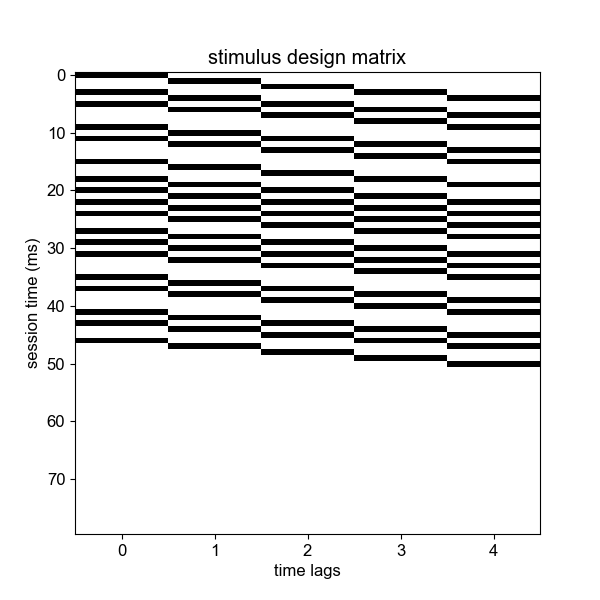

In [239]:
import os
from os.path import join as pjoin

save_dir = '/Users/gabriel/Desktop/BSN_figures/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

plt.figure(figsize=(6, 6))
plt.imshow(design_matrix[0:80, :], aspect='auto', cmap='gray_r')
plt.xlabel('time lags')
plt.ylabel('session time (ms)')
plt.title('stimulus design matrix')
# plt.savefig(pjoin(save_dir, "stimulus_design_matrix.svg"), format='svg', dpi=300, bbox_inches='tight')
plt.show()

In [240]:
from sklearn.model_selection import KFold

X = design_matrix
y = binned_spike_rate
y = (y - y.mean(axis=0)) / y.std(axis=0) 

n_folds = 10
kf = KFold(n_splits = n_folds, shuffle = True)

models = []
models_shuffle = []
cv_R_squared = []
cv_R_squared_shuffle = []

for i, (train_index, test_index) in enumerate(kf.split(X = X, y = y)): 
    X_train, X_test = X[train_index], X[test_index]
    X_train_shuffled = X_train[np.random.permutation(X_train.shape[0]),:]
    y_train, y_test = y[train_index], y[test_index]

    models.append(LinearRegression(fit_intercept=True).fit(X=X_train, y=y_train))
    models_shuffle.append(LinearRegression(fit_intercept=True).fit(X=X_train_shuffled, y=y_train))
    cv_R_squared.append(models[-1].score(X_test, y_test))  
    cv_R_squared_shuffle.append(models_shuffle[-1].score(X_test, y_test))

best_model = np.where(np.array(cv_R_squared) == np.max(cv_R_squared))[0][0]

In [241]:
cv_R_squared[best_model]

0.0044760278654697346

/var/folders/k4/_l1cqd4d0gn02n75d0rrj10h0000gr/T/ipykernel_39835/2739680999.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


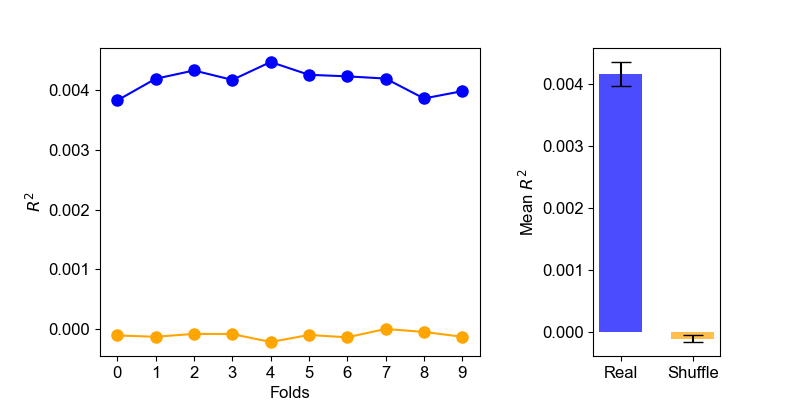

In [242]:
import numpy as np
from scipy import stats

# Plot the R² per fold
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [3, 1], 'wspace': 0.45})

# Line plot showing R² across folds
ax1.plot(cv_R_squared, 'o-', label='real', color='blue', markersize=8)
ax1.plot(np.array(cv_R_squared_shuffle), 'o-', label='shuffle', color='orange', markersize=8)
ax1.set_ylabel('$R^2$')
ax1.set_xlabel('Folds')
ax1.set_xticks(np.arange(0, n_folds))
# ax1.set_title('Model performance across folds')

# Bar plot showing mean R² values
mean_r2_real = np.mean(cv_R_squared)
mean_r2_shuffle = np.mean(cv_R_squared_shuffle)
std_r2_real = np.std(cv_R_squared)
std_r2_shuffle = np.std(cv_R_squared_shuffle)

bar_positions = [0, 1]
bar_heights = [mean_r2_real, mean_r2_shuffle]
bar_errors = [std_r2_real, std_r2_shuffle]

bars = ax2.bar(bar_positions, bar_heights, yerr=bar_errors, width=0.6, 
    color=['blue', 'orange'], capsize=7, alpha=0.7)
ax2.set_xticks(bar_positions)
ax2.set_xticklabels(['Real', 'Shuffle'])
ax2.set_ylabel('Mean $R^2$')

plt.tight_layout()
# plt.savefig(pjoin(save_dir, "movement_stimulus_model_scores_across_folds.svg"), format='svg', dpi=300, bbox_inches='tight')


#### Plotting event-triggered avg PSTH

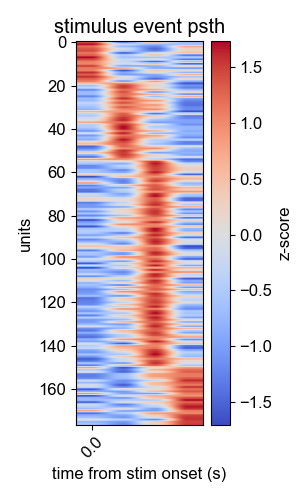

In [ ]:
pop_peth, timebin_edges, _ = population_peth(
        all_spike_times=spike_times_per_unit,
        alignment_times=all_stims,
        pre_seconds=0.025,
        post_seconds=post_seconds,
        binwidth_ms=bin_size*1000,
        pad=0,
        kernel=None,
    )

mean_psth = pop_peth.mean(axis=1)


# Normalize the PSTH for each unit
normalized_mean_psth = (mean_psth - mean_psth.mean(axis=1, keepdims=True)) / mean_psth.std(axis=1, keepdims=True)
peak_indices = np.argmax(normalized_mean_psth, axis=1)
peak_sort_indices = np.argsort(peak_indices) #row_sort_indices is for cumsum of model weights, peak_sort_indices is for earlier responses
sorted_psth = normalized_mean_psth[peak_sort_indices]

save_dir = '/Users/gabriel/Desktop/encoding_model/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

plt.figure(figsize=(3,5))
plt.imshow(sorted_psth, aspect='auto', cmap='coolwarm') # for sorting my model cumsum use `normalized_mean_psth[row_sort_indices]`
plt.colorbar(label = 'z-score')
plt.xticks(np.arange(0, n_timepoints, 5), (np.arange(0, n_timepoints, 5))*bin_size, rotation=45)
plt.xlabel('time from stim onset (s)')
plt.ylabel('units')
plt.title('stimulus event psth')
plt.tight_layout()
# plt.savefig(pjoin(save_dir, "peak_sort_stimulus_event_psth.png"), format='png', dpi=300, bbox_inches='tight')


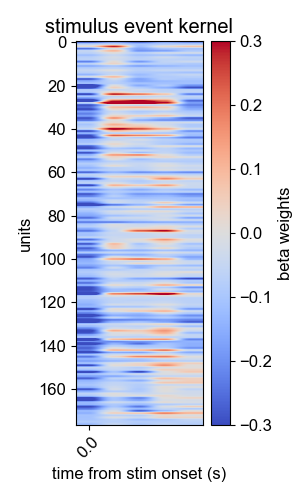

In [ ]:
weights = models[best_model].coef_

row_cumsum = np.cumsum(weights[:,:n_timepoints], axis=1)
row_sort_indices = np.argsort(row_cumsum[:, -1])[::-1]

plt.figure(figsize=(3, 5))
plt.imshow(weights[peak_sort_indices], aspect='auto', cmap='coolwarm', vmin=-0.3, vmax=0.3)
plt.colorbar(label = 'beta weights')
plt.xticks(np.arange(0, n_timepoints, 5), (np.arange(0, n_timepoints, 5))*bin_size, rotation=45)
plt.xlabel('time from stim onset (s)')
plt.ylabel('units')
plt.title('stimulus event kernel')
plt.tight_layout()
# plt.savefig(pjoin(save_dir, "stimulus_event_kernel_weights.png"), format='png', dpi=300, bbox_inches='tight')

#### Making sure stim alignment is correct

In [229]:
peak_sort_indices[80]

137

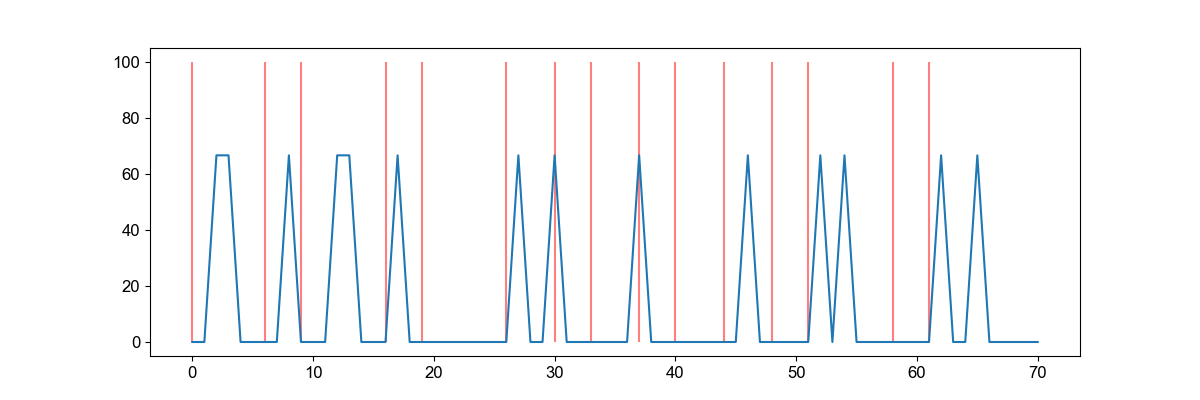

In [237]:
#i want to plot the binned spike rate for the timebins around the events in all_stims[:15]
#find the indices of the timebins around the events
event_indices = np.searchsorted(time_bins[:-1], all_stims[:15], side='right') - 1

plt.figure(figsize=(12, 4))
plt.vlines(event_indices, ymin = 0, ymax = 100, color='r', alpha=0.5)
plt.plot(binned_spike_rate[event_indices[0]:event_indices[-1]+10, peak_sort_indices[52]])

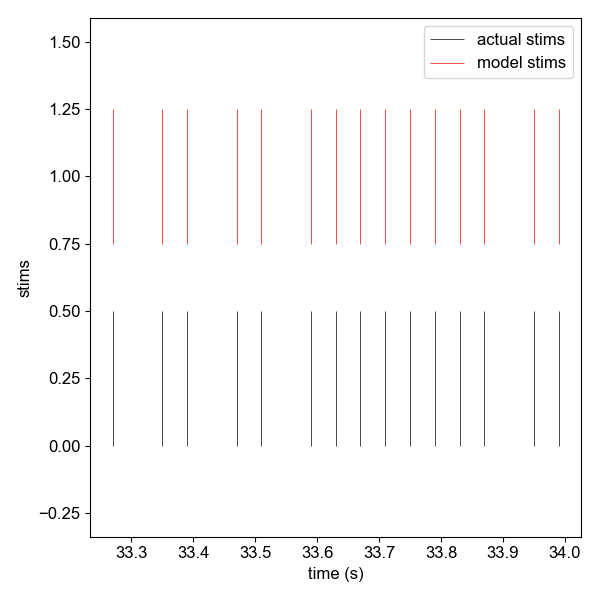

In [ ]:
plt.figure(figsize=(6, 6))
ax = plt.gca()
plt.eventplot(all_stims[:15], color='k', lineoffsets=0.25, linelengths=0.5, linewidths=0.5, label='actual stims')
plt.plot(binned_spike_rate[:, peak_sort_indices], color='r', lineoffsets=1, linelengths=0.5, linewidths=0.5, label='model stims')
plt.xlabel('time (s)')
plt.ylabel('stims')
plt.legend()
plt.tight_layout()